In [57]:
import nest_asyncio

from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv

nest_asyncio.apply()
load_dotenv()

True

# Parallel Nodes in LangGraph

### Variante 1: StateGraph mit “parallel edges” (Fan-out → Fan-in)

In [ ]:
class S(TypedDict, total=False):
    input: str
    b_out: str
    c_out: str
    merged: str

def node_a(state: S) -> S:
    return {"input": state["input"]}

def node_b(state: S) -> S:
    return {"b_out": f"B saw: {state['input']}"}

def node_c(state: S) -> S:
    return {"c_out": f"C saw: {state['input']}"}

def node_d(state: S) -> S:
    # Join: both b_out and c_out should exist now
    return {"merged": f"{state.get('b_out')} | {state.get('c_out')}"}

g = StateGraph(S)

g.add_node("A", node_a)
g.add_node("B", node_b)
g.add_node("C", node_c)
g.add_node("D", node_d)

g.set_entry_point("A")

# Fan-out: A -> B and A -> C
g.add_edge("A", "B")
g.add_edge("A", "C")

# Fan-in: B -> D and C -> D
# D will run once the scheduler has both paths completed.
g.add_edge("B", "D")
g.add_edge("C", "D")

g.add_edge("D", END)

graph = g.compile()

result = graph.invoke({"input": "hello"})
print(result["merged"])


B saw: hello | C saw: hello


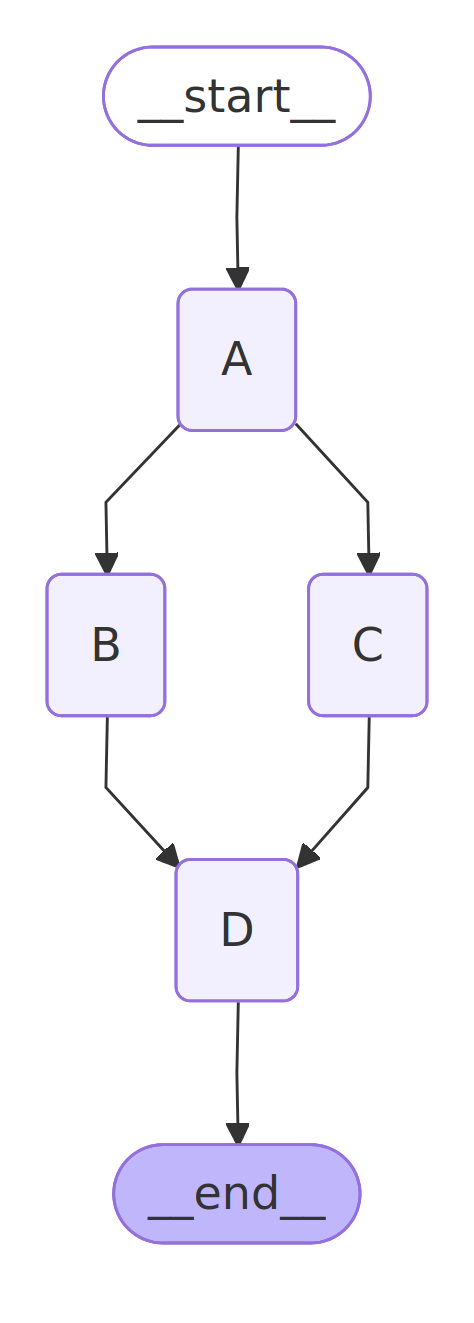

In [2]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

### Variante 2: Wenn du wirklich “gleichzeitig” im selben Node willst (Async in einem Knoten)

Manchmal ist’s einfacher: B und C sind nur zwei Calls (z.B. zwei Agents) und du willst die in einem Node

In [3]:
import asyncio
from typing import TypedDict
from langgraph.graph import StateGraph, END

class S(TypedDict, total=False):
    input: str
    b_out: str
    c_out: str
    merged: str

async def run_b(text: str) -> str:
    # await agent_b.ainvoke(...)
    return f"B saw: {text}"

async def run_c(text: str) -> str:
    # await agent_c.ainvoke(...)
    return f"C saw: {text}"

async def node_bc_parallel(state: S) -> S:
    b_out, c_out = await asyncio.gather(
        run_b(state["input"]),
        run_c(state["input"]),
    )
    return {"b_out": b_out, "c_out": c_out}

def node_d(state: S) -> S:
    return {"merged": f"{state['b_out']} | {state['c_out']}"}

g = StateGraph(S)
g.add_node("BC", node_bc_parallel)
g.add_node("D", node_d)

g.set_entry_point("BC")
g.add_edge("BC", "D")
g.add_edge("D", END)

graph = g.compile()
res = await graph.ainvoke({"input": "hello"})
print(res["merged"])


B saw: hello | C saw: hello


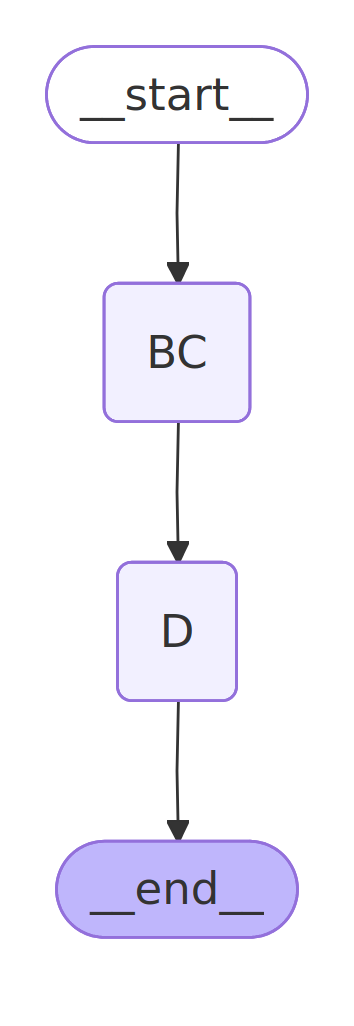

In [4]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)


In [5]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	BC(BC)
	D(D)
	__end__([<p>__end__</p>]):::last
	BC --> D;
	__start__ --> BC;
	D --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



# ChromaDB

In [9]:
import chromadb
from rich.pretty import Pretty
# chroma_client = chromadb.PersistentClient(path="./chroma_data")
chroma_client = chromadb.HttpClient()

# switch `create_collection` to `get_or_create_collection` to avoid creating a new collection every time
collection = chroma_client.get_or_create_collection(name="my_collection")

# switch `add` to `upsert` to avoid adding the same documents every time
collection.upsert(
    documents=[
        "This is a document about pineapple",
        "This is a document about oranges"
    ],
    ids=["id1", "id2"]
)

results = collection.query(
    query_texts=["This is a query document about florida"], # Chroma will embed this for you
    n_results=2 # how many results to return
)

Pretty(results)


{
    'ids': [['id2', 'id1']],
    'distances': [[1.1462138, 1.3015385]],
    'embeddings': None,
    'metadatas': [[None, None]],
    'documents': [['This is a document about oranges', 'This is a document about pineapple']],
    'uris': None,
    'data': None,
    'included': ['metadatas', 'documents', 'distances']
}

In [17]:
chroma_client = chromadb.PersistentClient(path="./chroma_data")
chroma_client.list_collections()

[Collection(name=cultpass), Collection(name=udahub)]

In [18]:
Pretty(chroma_client.get_collection(name="cultpass").get())

{
    'ids': [
        'experience_6cb08f',
        'experience_0611de',
        'experience_4fdccd',
        'experience_b258f5',
        'experience_399fa9',
        'experience_dce4ed',
        'experience_4e10c3'
    ],
    'embeddings': None,
    'documents': [
        "Discover the origins and vibrant traditions of Pernambuco's Carnival.",
        'Glide across calm waters at golden hour with all gear included.',
        'Wander through colorful streets and learn about Afro-Brazilian history.',
        'Dance the night away at a traditional samba club in the Lapa arches.',
        'Take a guided trip to one of the New Seven Wonders of the World with historical context.',
        'Enjoy a guided visit to the São Paulo Museum of Art with insights into its top collections.',
        "Cycle through the city's most iconic park with stops for photos and history."
    ],
    'uris': None,
    'included': ['metadatas', 'documents'],
    'data': None,
    'metadatas': [
        {'type': 'experience', 'title': 'Carnival History Tour in Olinda', 'experience_id': '6cb08f'},
        {'type': 'experience', 'experience_id': '0611de', 'title': 'Sunset Paddleboarding'},
        {'experience_id': '4fdccd', 'title': 'Pelourinho Colonial Walk', 'type': 'experience'},
        {'type': 'experience', 'title': 'Samba Night at Lapa', 'experience_id': 'b258f5'},
        {'type': 'experience', 'experience_id': '399fa9', 'title': 'Christ the Redeemer Experience'},
        {'experience_id': 'dce4ed', 'type': 'experience', 'title': 'Modern Art at MASP'},
        {'type': 'experience', 'title': 'Ibirapuera Park Bike Ride', 'experience_id': '4e10c3'}
    ]
}

In [19]:
Pretty(chroma_client.get_collection(name="udahub").get())

{
    'ids': [
        'knowledge_0c57daf0-6434-4496-86f7-26fe5545377c',
        'knowledge_924b8e14-d434-4c4d-8455-06386aa06178',
        'knowledge_8f668133-d9ca-4b42-a38d-baa370e1f75b',
        'knowledge_1751b7a8-9c58-4b9f-8074-d9e85f68d220'
    ],
    'embeddings': None,
    'documents': [
        'If a user asks how to reserve an event:\n\n- Guide them to the CultPass app\n- Instruct them to browse the
experience catalog and tap \'Reserve\'\n- If it\'s a premium or limited event, check if reservation confirmation is
required via email\n- Remind them to arrive at least 15 minutes early with their QR code visible\n\n**Suggested 
phrasing:**\n"You can reserve an experience by opening the CultPass app, selecting your desired event, and tapping 
\'Reserve\'. Be sure to arrive 15 minutes early with your QR code ready."',
        'Each user is entitled to 4 cultural experiences per month, which may include:\n- Art exhibitions\n- Museum
entries\n- Music concerts\n- Film screenings and more\n\nSome premium experiences may require an additional fee 
(visible in the app).\n\n**Suggested phrasing:**\n"Your CultPass subscription includes 4 curated experiences each 
month. You can choose from museums, concerts, film events and more. Premium events may have an extra cost, which is
shown during reservation."',
        'Users can manage their subscription via the app > \'My Account\' > \'Manage Plan\'.\n\n- Cancel: Effective
at the end of the billing cycle\n- Pause: Preserves user data, resumes automatically when reactivated\n- Do NOT 
offer refunds unless approved by support lead\n\n**Suggested phrasing:**\n"You can cancel or pause your 
subscription at any time via the \'My Account\' section in the CultPass app. Cancelation takes effect at the end of
your billing cycle."',
        'Most login issues are resolved with password reset:\n\n- Ask the user to tap \'Forgot Password\' on the 
login screen\n- Ensure they are using the correct registered email\n- If they did not receive the reset email, 
check spam folder or retry after 10 minutes\n- For persistent login issues, escalate to human 
support\n\n**Suggested phrasing:**\n"Try tapping \'Forgot Password\' on the login screen. Make sure you\'re using 
the email associated with your account. If the email doesn\'t arrive, check spam or try again in a few minutes."'
    ],
    'uris': None,
    'included': ['metadatas', 'documents'],
    'data': None,
    'metadatas': [
        {
            'article_id': '0c57daf0-6434-4496-86f7-26fe5545377c',
            'account_id': 'cultpass',
            'tags': 'reservation, events, booking, attendance',
            'title': 'How to Reserve a Spot for an Event',
            'type': 'knowledge'
        },
        {
            'tags': 'subscription, benefits, pricing, access',
            'article_id': '924b8e14-d434-4c4d-8455-06386aa06178',
            'account_id': 'cultpass',
            'title': "What's Included in a CultPass Subscription",
            'type': 'knowledge'
        },
        {
            'article_id': '8f668133-d9ca-4b42-a38d-baa370e1f75b',
            'type': 'knowledge',
            'title': 'How to Cancel or Pause a Subscription',
            'account_id': 'cultpass',
            'tags': 'cancelation, pause, subscription, billing'
        },
        {
            'tags': 'login, password, access, escalation',
            'article_id': '1751b7a8-9c58-4b9f-8074-d9e85f68d220',
            'title': 'How to Handle Login Issues?',
            'account_id': 'cultpass',
            'type': 'knowledge'
        }
    ]
}

In [49]:
from pydantic import BaseModel, Field

class KnowledgeBaseEntry(BaseModel):
    collection: str = Field(description="The collection this entry belongs to")
    id: str = Field(description="The unique identifier for this knowledge entry in the collection")
    title: str = Field(description="The title of the knowledge entry")
    content: str = Field(description="The content of the knowledge entry")

class UdaHubKnowledgeEntry(KnowledgeBaseEntry):
    article_id: str = Field(description="The unique identifier for the UdaHub article")
    account_id: str = Field(description="The account identifier associated with the UdaHub article")
    

collection = chroma_client.get_collection(name="udahub")
results = collection.query(
    query_texts=["I forgot my password"],
    where={
        "type": "knowledge"
    },
    n_results=3
)
Pretty(results)


{
    'ids': [
        [
            'knowledge_1751b7a8-9c58-4b9f-8074-d9e85f68d220',
            'knowledge_8f668133-d9ca-4b42-a38d-baa370e1f75b',
            'knowledge_0c57daf0-6434-4496-86f7-26fe5545377c'
        ]
    ],
    'embeddings': None,
    'documents': [
        [
            'Most login issues are resolved with password reset:\n\n- Ask the user to tap \'Forgot Password\' on 
the login screen\n- Ensure they are using the correct registered email\n- If they did not receive the reset email, 
check spam folder or retry after 10 minutes\n- For persistent login issues, escalate to human 
support\n\n**Suggested phrasing:**\n"Try tapping \'Forgot Password\' on the login screen. Make sure you\'re using 
the email associated with your account. If the email doesn\'t arrive, check spam or try again in a few minutes."',
            'Users can manage their subscription via the app > \'My Account\' > \'Manage Plan\'.\n\n- Cancel: 
Effective at the end of the billing cycle\n- Pause: Preserves user data, resumes automatically when reactivated\n- 
Do NOT offer refunds unless approved by support lead\n\n**Suggested phrasing:**\n"You can cancel or pause your 
subscription at any time via the \'My Account\' section in the CultPass app. Cancelation takes effect at the end of
your billing cycle."',
            'If a user asks how to reserve an event:\n\n- Guide them to the CultPass app\n- Instruct them to browse
the experience catalog and tap \'Reserve\'\n- If it\'s a premium or limited event, check if reservation 
confirmation is required via email\n- Remind them to arrive at least 15 minutes early with their QR code 
visible\n\n**Suggested phrasing:**\n"You can reserve an experience by opening the CultPass app, selecting your 
desired event, and tapping \'Reserve\'. Be sure to arrive 15 minutes early with your QR code ready."'
        ]
    ],
    'uris': None,
    'included': ['metadatas', 'documents', 'distances'],
    'data': None,
    'metadatas': [
        [
            {
                'type': 'knowledge',
                'account_id': 'cultpass',
                'article_id': '1751b7a8-9c58-4b9f-8074-d9e85f68d220',
                'tags': 'login, password, access, escalation',
                'title': 'How to Handle Login Issues?'
            },
            {
                'account_id': 'cultpass',
                'type': 'knowledge',
                'title': 'How to Cancel or Pause a Subscription',
                'tags': 'cancelation, pause, subscription, billing',
                'article_id': '8f668133-d9ca-4b42-a38d-baa370e1f75b'
            },
            {
                'article_id': '0c57daf0-6434-4496-86f7-26fe5545377c',
                'tags': 'reservation, events, booking, attendance',
                'account_id': 'cultpass',
                'type': 'knowledge',
                'title': 'How to Reserve a Spot for an Event'
            }
        ]
    ],
    'distances': [[1.0833120346069336, 1.5086405277252197, 1.640567421913147]]
}

In [41]:
range(len(results["ids"][0]))

range(0, 3)

In [43]:
bla = []
for i in range(len(results["ids"][0])):
    entry = UdaHubKnowledgeEntry(
        collection="udahub",
        id=results["ids"][0][i],
        title=results["metadatas"][0][i]["title"],
        content=results["documents"][0][i],
        article_id=results["metadatas"][0][i]["article_id"],
        account_id=results["metadatas"][0][i]["account_id"],
    )
    bla.append(entry)

Pretty(bla)

[
    UdaHubKnowledgeEntry(
        collection='udahub',
        id='knowledge_1751b7a8-9c58-4b9f-8074-d9e85f68d220',
        title='How to Handle Login Issues?',
        content='Most login issues are resolved with password reset:\n\n- Ask the user to tap \'Forgot Password\' 
on the login screen\n- Ensure they are using the correct registered email\n- If they did not receive the reset 
email, check spam folder or retry after 10 minutes\n- For persistent login issues, escalate to human 
support\n\n**Suggested phrasing:**\n"Try tapping \'Forgot Password\' on the login screen. Make sure you\'re using 
the email associated with your account. If the email doesn\'t arrive, check spam or try again in a few minutes."',
        article_id='1751b7a8-9c58-4b9f-8074-d9e85f68d220',
        account_id='cultpass'
    ),
    UdaHubKnowledgeEntry(
        collection='udahub',
        id='knowledge_8f668133-d9ca-4b42-a38d-baa370e1f75b',
        title='How to Cancel or Pause a Subscription',
        content='Users can manage their subscription via the app > \'My Account\' > \'Manage Plan\'.\n\n- Cancel: 
Effective at the end of the billing cycle\n- Pause: Preserves user data, resumes automatically when reactivated\n- 
Do NOT offer refunds unless approved by support lead\n\n**Suggested phrasing:**\n"You can cancel or pause your 
subscription at any time via the \'My Account\' section in the CultPass app. Cancelation takes effect at the end of
your billing cycle."',
        article_id='8f668133-d9ca-4b42-a38d-baa370e1f75b',
        account_id='cultpass'
    ),
    UdaHubKnowledgeEntry(
        collection='udahub',
        id='knowledge_0c57daf0-6434-4496-86f7-26fe5545377c',
        title='How to Reserve a Spot for an Event',
        content='If a user asks how to reserve an event:\n\n- Guide them to the CultPass app\n- Instruct them to 
browse the experience catalog and tap \'Reserve\'\n- If it\'s a premium or limited event, check if reservation 
confirmation is required via email\n- Remind them to arrive at least 15 minutes early with their QR code 
visible\n\n**Suggested phrasing:**\n"You can reserve an experience by opening the CultPass app, selecting your 
desired event, and tapping \'Reserve\'. Be sure to arrive 15 minutes early with your QR code ready."',
        article_id='0c57daf0-6434-4496-86f7-26fe5545377c',
        account_id='cultpass'
    )
]

### Top Level Agent

In [7]:
from typing import Literal, Protocol, Optional, Sequence
from langgraph.graph.message import MessagesState
from langgraph.types import Command
from langgraph.graph import START, END, StateGraph
from langgraph.types import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage


class UserInterface(Protocol):
    def next_message(self) -> Optional[str]:
        """Return next user message, or None if the stream is finished."""


class ListUserInterface:
    messages: Sequence[str]
    _i: int = 0

    def next_message(self) -> Optional[str]:
        if self._i >= len(self.messages):
            return None
        msg = self.messages[self._i]
        self._i += 1
        return msg
    

class ConsoleUserInterface:
    def next_message(self) -> str | None:
        msg = input("> ").strip()
        if msg.lower() in {"exit", "quit"}:
            return None
        return msg

class UdaHubState(MessagesState):
    enriched: bool

    

def validation_agent(state: UdaHubState) -> Command[Literal["enrichment_agent", "supervisor_agent", END]]:
    print("Called validation_agent")
    if state["enriched"]:
        return Command(goto="supervisor_agent")

    return Command(
        goto="enrichment_agent"
    )

def enrichment_agent(state: UdaHubState) -> Command[Literal["supervisor_agent"]]:
    print("Called enrichment_agent")
    return Command(
        goto="supervisor_agent",
        update={
            "enriched": True
        },
    )

def supervisor_agent(state: UdaHubState, config: RunnableConfig) -> Command[Literal["memorization_agent"]]:
    settings = config.get("configurable", {})
    ui: UserInterface = settings.get("user_interface") or ConsoleUserInterface()

    messages: list[HumanMessage] = []

    message = ui.next_message()
    while message is not None:
        messages.append(HumanMessage(content=message))
        message = ui.next_message()

    print("Called supervisor_agent")
    return Command(
        goto="memorization_agent",
        update={
            "messages": messages,
        }
    )

def memorization_agent(state: UdaHubState) -> Command[Literal[END]]:
    print("Called memorization_agent")
    return Command(
        goto=END
    )


workflow = StateGraph(UdaHubState)
workflow.add_node(validation_agent)
workflow.add_node(enrichment_agent)
workflow.add_node(supervisor_agent)
workflow.add_node(memorization_agent)

workflow.add_edge(START, "validation_agent")
graph = workflow.compile(
    checkpointer = MemorySaver(),
)
graph.invoke(
    input={
        "enriched": False
    },
    config={
            "configurable": {
                "thread_id": 4711,
                "user_interface": ConsoleUserInterface()
            }
        }
)

Called validation_agent
Called enrichment_agent
Called supervisor_agent
Called memorization_agent


{'messages': [HumanMessage(content='Hallo', additional_kwargs={}, response_metadata={}, id='918827d5-13b3-4e84-9d31-ba0b5fbac75e'),
  HumanMessage(content='Welt', additional_kwargs={}, response_metadata={}, id='28ba916d-868d-4635-9846-4652dffccf4d')],
 'enriched': True}

In [8]:
graph.invoke(
    input={},
    config={
            "configurable": {
                "thread_id": 4711,
                "user_interface": ConsoleUserInterface()
            }
        }
)

Called validation_agent
Called supervisor_agent
Called memorization_agent


{'messages': [HumanMessage(content='Hallo', additional_kwargs={}, response_metadata={}, id='918827d5-13b3-4e84-9d31-ba0b5fbac75e'),
  HumanMessage(content='Welt', additional_kwargs={}, response_metadata={}, id='28ba916d-868d-4635-9846-4652dffccf4d'),
  HumanMessage(content='huhu', additional_kwargs={}, response_metadata={}, id='aef8a4ba-cd34-4181-ad2f-2efe425ca0c9')],
 'enriched': True}

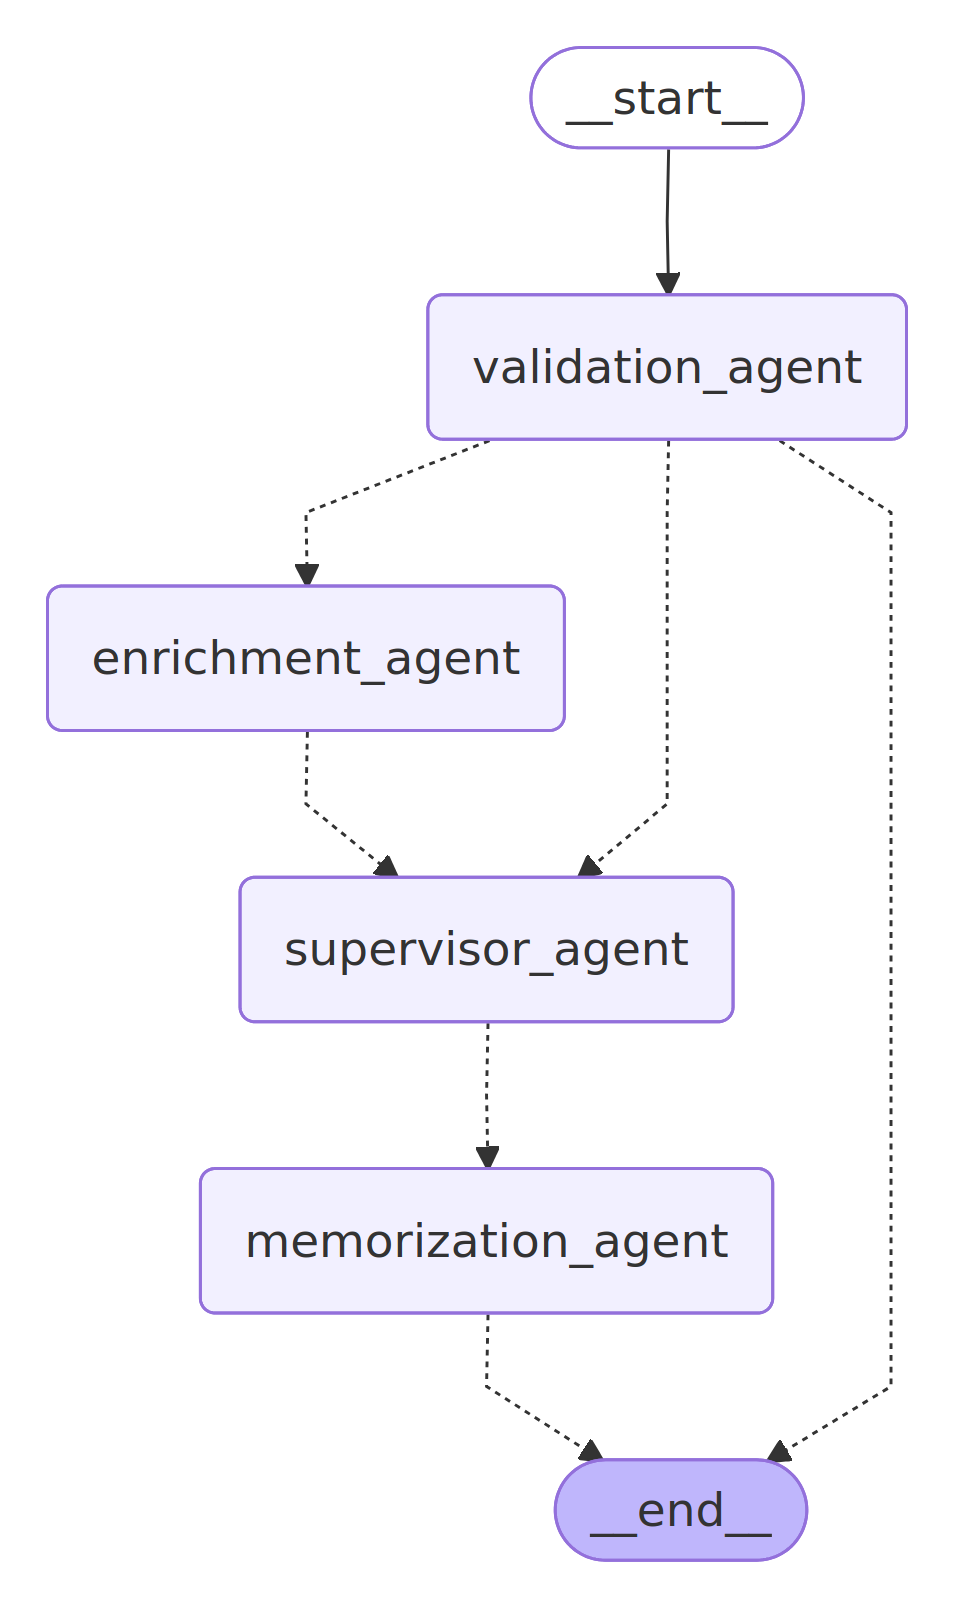

In [26]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

# MCP Integration

In [53]:
from langchain.messages import SystemMessage, HumanMessage
from langchain_mcp_adapters.client import MultiServerMCPClient, StreamableHttpConnection
# from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from rich.pretty import Pretty

client = MultiServerMCPClient(  
    {
        "math": StreamableHttpConnection(
            url="http://localhost:8000/mcp",
            transport="streamable_http"
        )
    }
)

tools = await client.get_tools() 
Pretty(tools)

[
    StructuredTool(
        name='sync_cultpass_experiences',
        description='Synchronize the Cultpass experiences into the knowledgebase.',
        args_schema={'properties': {}, 'type': 'object'},
        metadata={'_meta': {'_fastmcp': {'tags': ['cultpass', 'experiences', 'sync']}}},
        response_format='content_and_artifact',
        coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f5b180f3600>
    ),
    StructuredTool(
        name='sync_udahub_knowledgebase',
        description='Synchronize the UdaHub knowledge entries into the knowledgebase.',
        args_schema={'properties': {}, 'type': 'object'},
        metadata={'_meta': {'_fastmcp': {'tags': ['sync', 'udahub']}}},
        response_format='content_and_artifact',
        coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f5a64116a20>
    ),
    StructuredTool(
        name='query_udahub_knowledgebase',
        description='Query the UdaHub knowledgebase for learnings related to a given customer.',
        args_schema={
            '$defs': {
                'UdaHubKnowledgeBaseQuery': {
                    'properties': {
                        'query_text': {'description': 'The search query string', 'type': 'string'},
                        'n_results': {
                            'default': 5,
                            'description': 'The number of results to return from the query',
                            'type': 'integer'
                        },
                        'account_id': {
                            'description': 'The ID of the UdaHub account to filter the knowledge entries by',
                            'type': 'string'
                        }
                    },
                    'required': ['query_text', 'account_id'],
                    'type': 'object'
                }
            },
            'properties': {'query': {'$ref': '#/$defs/UdaHubKnowledgeBaseQuery'}},
            'required': ['query'],
            'type': 'object'
        },
        metadata={'_meta': {'_fastmcp': {'tags': ['cultpass', 'knowledge', 'query']}}},
        response_format='content_and_artifact',
        coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f5a64116160>
    ),
    StructuredTool(
        name='query_cultpass_experiences',
        description='Query the Cultpass experiences knowledgebase.',
        args_schema={
            '$defs': {
                'KnowledgeBaseQuery': {
                    'properties': {
                        'query_text': {'description': 'The search query string', 'type': 'string'},
                        'n_results': {
                            'default': 5,
                            'description': 'The number of results to return from the query',
                            'type': 'integer'
                        }
                    },
                    'required': ['query_text'],
                    'type': 'object'
                }
            },
            'properties': {'query': {'$ref': '#/$defs/KnowledgeBaseQuery'}},
            'required': ['query'],
            'type': 'object'
        },
        metadata={'_meta': {'_fastmcp': {'tags': ['cultpass', 'experiences', 'knowledge', 'query']}}},
        response_format='content_and_artifact',
        coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f5a0bff4a40>
    )
]

In [47]:
resources = await client.get_resources() 
Pretty(resources)

[
    Blob(
        metadata={'uri': AnyUrl('data://config')},
        data='{"chroma_db_path":"./chroma_data","cultpass_db_path":"sqlite:///starter/data/external/cultpass.db","u
dahub_db_path":"sqlite:///starter/data/core/udahub.db"}',
        mimetype='application/json'
    )
]

In [59]:
from langchain.messages import SystemMessage, HumanMessage
from langchain_mcp_adapters.client import MultiServerMCPClient, StreamableHttpConnection
# from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from rich.pretty import Pretty

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

client = MultiServerMCPClient(  
    {
        "math": StreamableHttpConnection(
            url="http://localhost:8000/mcp",
            transport="streamable_http"
        )
    }
)

tools = await client.get_tools()          # <-- Tools dynamisch vom Server
agent = create_agent(
    model=llm,
    system_prompt=SystemMessage(
            content=(
                """
                You are UdaHub, a chatbot that third-party companies use to answer questions of their users.
                Always use the available tools to answer the questions.

                You are currently answering questions for customer Cultpass (id=cultpass).
                """
            )
        ),
    tools=tools
)

result = await agent.ainvoke({
    "messages": HumanMessage("How do I reset my password?")
})

print(result["messages"][-1].content)

I couldn't find specific information on how to reset your password. However, you can typically reset your password by following these general steps:

1. Go to the login page of the Cultpass website or app.
2. Click on the "Forgot Password?" link.
3. Enter your registered email address.
4. Check your email for a password reset link.
5. Follow the instructions in the email to create a new password.

If you need further assistance, please contact Cultpass customer support directly.


In [10]:
Pretty(tools)

[
    StructuredTool(
        name='add',
        description='Add two numbers.\n\nArgs:\n    a: First operand.\n    b: Second operand.\n\nReturns:\n    The 
sum of a and b.',
        args_schema={
            'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}},
            'required': ['a', 'b'],
            'type': 'object'
        },
        metadata={'_meta': {'_fastmcp': {'tags': ['hallo', 'welt']}}},
        response_format='content_and_artifact',
        coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f76c59a7a60>
    ),
    StructuredTool(
        name='multiply',
        description='Multiply two numbers\n\nArgs',
        args_schema={
            'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}},
            'required': ['a', 'b'],
            'type': 'object'
        },
        metadata={'_meta': {'_fastmcp': {'tags': []}}},
        response_format='content_and_artifact',
        coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f76c59bfe20>
    )
]